In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [3]:
# Dataset paths
first_set_path = r'Dataset/First Set'
second_set_path = r'Dataset/Second Set'

# Image categories
categories = ['Normal', 'OSCC']

In [4]:
def load_images_from_folder(folder_path, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(folder_path, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            if category == 'Normal':
                labels.append(0) 
            else:
                labels.append(1)
    return np.array(images), np.array(labels)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,     
    width_shift_range=0.1,  
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True
)


In [6]:
# Load 100x images
x_100x, y_100x = load_images_from_folder(first_set_path)

# Load 400x images
x_400x, y_400x = load_images_from_folder(second_set_path)

# Combine the datasets
x_data = np.concatenate((x_100x, x_400x), axis=0)
y_data = np.concatenate((y_100x, y_400x), axis=0)


# Shuffle the dataset
from sklearn.utils import shuffle
x_data, y_data = shuffle(x_data, y_data, random_state=42)

In [7]:
unique, counts = np.unique(y_data, return_counts=True)
print(dict(zip(unique, counts)))

{0: 290, 1: 934}


In [ ]:
# # ==================================ImageDataGenerator on Just Normal========================================== #


# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen_normal = ImageDataGenerator(
#     rotation_range=10,     
#     width_shift_range=0.1,  
#     height_shift_range=0.1,
#     shear_range=0.15,
#     zoom_range=0.1,
#     horizontal_flip=True
# )

# # Oversample the Normal class
# x_normal = x_data[y_data == 0]
# y_normal = y_data[y_data == 0]
# x_oscc = x_data[y_data == 1]
# y_oscc = y_data[y_data == 1]



# # Apply this only to the Normal class
# x_normal_augmented, y_normal_augmented = datagen_normal.flow(
#     x_normal, y_normal, batch_size=len(x_normal), shuffle=False
# ).next()

# # Combine augmented data with original data
# x_data_balanced = np.concatenate([x_oscc, x_normal_augmented], axis=0)
# y_data_balanced = np.concatenate([y_oscc, y_normal_augmented], axis=0)



# x_data = x_data_balanced
# y_data = y_data_balanced

In [7]:
# # ==================================RE-Sample========================================== #


# from sklearn.utils import resample

# # Oversample the Normal class
# x_normal = x_data[y_data == 0]
# y_normal = y_data[y_data == 0]
# x_oscc = x_data[y_data == 1]
# y_oscc = y_data[y_data == 1]

# x_normal_oversampled, y_normal_oversampled = resample(
#     x_normal, y_normal, 
#     replace=True, 
#     n_samples=len(y_oscc), 
#     random_state=42
# )

# x_data_balanced = np.concatenate([x_normal_oversampled, x_oscc], axis=0)
# y_data_balanced = np.concatenate([y_normal_oversampled, y_oscc], axis=0)


# x_data = x_data_balanced
# y_data = y_data_balanced

In [8]:
print(len(x_data), len(y_data))

1224 1224


In [9]:
unique, counts = np.unique(y_data, return_counts=True)
print(dict(zip(unique, counts)))

{0: 290, 1: 934}


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [12]:
# Augment the training set
train_datagen = datagen.flow(x_train, y_train, batch_size=32)

In [13]:
len(train_datagen)  

31

In [14]:
from tensorflow.keras.layers import BatchNormalization


model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),


    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

In [15]:
len(y_data)

1224

In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_data),
    y=y_data
)

class_weights = {i: weight for i, weight in enumerate(class_weights)}

In [32]:
class_weights = {0: 3.5, 1: 1.0}
class_weights

{0: 3.5, 1: 1.0}

In [33]:
history = model.fit(train_datagen, validation_data=(x_test, y_test), epochs=20, class_weight=class_weights)

Epoch 1/20
31/31 [==============================] - 34s 1s/step - loss: 0.6745 - accuracy: 0.7845 - val_loss: 1.5102 - val_accuracy: 0.4204
Epoch 2/20
31/31 [==============================] - 34s 1s/step - loss: 0.6306 - accuracy: 0.7967 - val_loss: 0.6002 - val_accuracy: 0.7020
Epoch 3/20
31/31 [==============================] - 34s 1s/step - loss: 0.6257 - accuracy: 0.7916 - val_loss: 0.9039 - val_accuracy: 0.7429
Epoch 4/20
31/31 [==============================] - 35s 1s/step - loss: 0.6383 - accuracy: 0.7967 - val_loss: 0.9344 - val_accuracy: 0.7796
Epoch 5/20
31/31 [==============================] - 35s 1s/step - loss: 0.6871 - accuracy: 0.7620 - val_loss: 0.6653 - val_accuracy: 0.6735
Epoch 6/20
31/31 [==============================] - 35s 1s/step - loss: 0.6274 - accuracy: 0.7926 - val_loss: 0.9792 - val_accuracy: 0.7020
Epoch 7/20
31/31 [==============================] - 35s 1s/step - loss: 0.6034 - accuracy: 0.7988 - val_loss: 0.5563 - val_accuracy: 0.8000
Epoch 8/20
31/31 [==

In [ ]:
# Train the model with augmented data
# history = model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)

Epoch 1/15
47/47 [==============================] - 55s 1s/step - loss: 0.6341 - accuracy: 0.6653 - val_loss: 0.9351 - val_accuracy: 0.5214
Epoch 2/15
47/47 [==============================] - 50s 1s/step - loss: 0.5835 - accuracy: 0.7142 - val_loss: 1.2073 - val_accuracy: 0.5214
Epoch 3/15
47/47 [==============================] - 53s 1s/step - loss: 0.4921 - accuracy: 0.7751 - val_loss: 1.3890 - val_accuracy: 0.5214
Epoch 4/15
10/47 [=====>........................] - ETA: 40s - loss: 0.4981 - accuracy: 0.7469

8/8 [==============================] - 2s 200ms/step


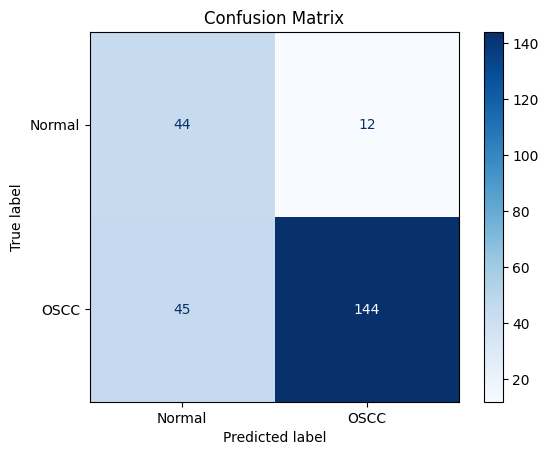

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [31]:
print(cm)

[[ 28  28]
 [ 24 165]]


In [12]:
#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

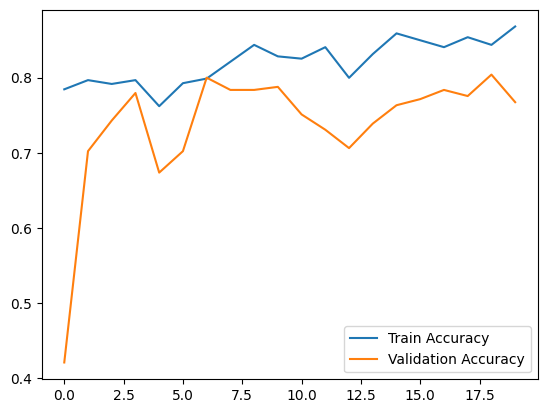

8/8 [==============================] - 2s 200ms/step - loss: 1.0255 - accuracy: 0.7673
Test Accuracy: 76.73%


In [35]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on test data
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

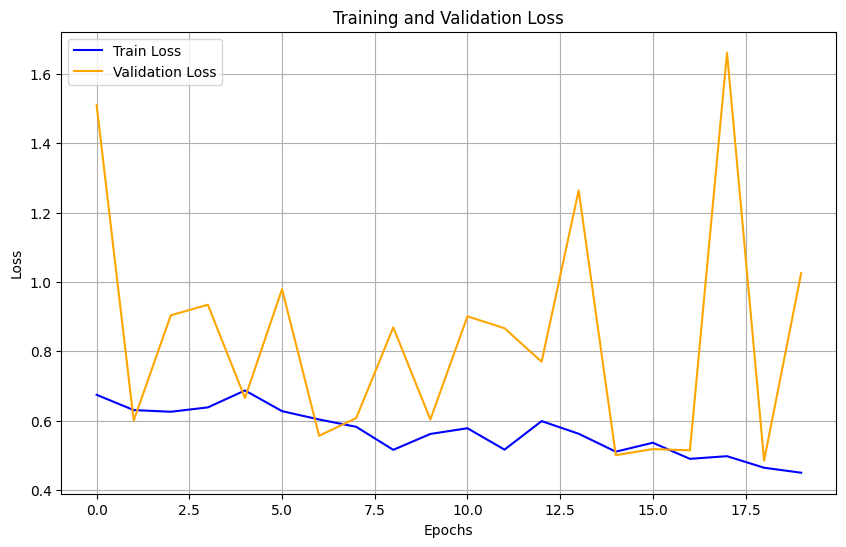

In [36]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.save("basicCNN_model.keras")

In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("basicCNN_model.keras")

# Print the model summary to verify
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

In [47]:
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    prediction = model.predict(img_array)
    print(prediction[0])
    if prediction[0] > 0.5:
        print("Prediction: OSCC")
    else:
        print("Prediction: Normal")
        
predict_image(r'Dataset/First Set/Normal/Normal_100x_1.jpg', model)
predict_image(r'Dataset/Second Set/Normal/Normal_400x_1.jpg', model)


# predict_image(r'OSCC_100x_54.jpg', model)
# predict_image(r'OSCC_100x_75.jpg', model)
# predict_image(r'OSCC_100x_98.jpg', model)
# predict_image(r'OSCC_100x_105.jpg', model)
# predict_image(r'OSCC_100x_112.jpg', model)
# predict_image(r'OSCC_100x_169.jpg', model)

predict_image(r'Dataset/First Set/OSCC/OSCC_100x_7.jpg', model)
predict_image(r'Dataset/Second Set/OSCC/OSCC_400x_422.jpg', model)     
        

1/1 [==============================] - 0s 26ms/step
[0.00466544]
Prediction: Normal
1/1 [==============================] - 0s 26ms/step
[0.18051292]
Prediction: Normal
1/1 [==============================] - 0s 24ms/step
[0.8820567]
Prediction: OSCC
1/1 [==============================] - 0s 27ms/step
[0.99748737]
Prediction: OSCC
